<a href="https://colab.research.google.com/github/mdsatria/aksarabali/blob/update/Transfer%20Learning/TransferLearningResnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 174kB 2.7MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip -qq "gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/train.zip"
!unzip -qq "gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/test.zip"

In [4]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla K80


## Data Loader

In [6]:
class AksaraBali(Dataset):
    def __init__(self, csv_file, root_dir, height=224, width=224, transform=None):
        self.annotations = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.height = height
        self.width = width
       
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = Image.open(img_path).resize((self.height, self.width))
        y_label = torch.tensor(self.annotations.iloc[index,2], dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
            
        return(image, y_label)

## Set Training Params

In [7]:
in_channel = 3
num_classes = 133
learning_rate = 0.001
batch_size = 64

# tranform
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.5005, 0.4670, 0.4174), std=(0.0813, 0.0534, 0.0932))])

train_set = AksaraBali(csv_file="gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/train_label.csv",
                       root_dir="train",
                       transform=my_transform)

test_set = AksaraBali(csv_file="gdrive/My Drive/Colab Notebooks/dataset/Aksara Bali/test_label.csv",
                       root_dir="test",
                       transform=my_transform)

#train_set = torch.utils.data(dataset)
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_set,
                          shuffle=False,
                         batch_size=batch_size)
#test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [8]:
def import_models(str_model_name):
  if str_model_name == "resnet":
    model = torchvision.models.resnet152(pretrained=True)
  elif str_model_name == "vgg": # Kurang cocok, tapi belum coba varian vgg yg lain, tapi kyknya sama aja.
    model = torchvision.models.vgg16(pretrained=True) 
  elif str_model_name == "mobilenet":
    model = torchvision.models.mobilenet_v2(pretrained=True)
  elif str_model_name == "inception": # tidak kompatible dgn input channel, perlu input 5x5
    model = torchvision.models.inception_v3(pretrained=True)
  elif str_model_name == "squeezenet":
    model = torchvision.models.squeezenet1_1(pretrained=True)
  elif str_model_name == "densenet": # semua jenis densenet --> GPU out of memory
    model = torchvision.models.densenet121(pretrained=True)

  return model

str_model_name = "mobilenet"
model = import_models(str_model_name)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [9]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(gpu)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Model pakai Pytorch Ignite

Inisiasi Training dan Evaluation Engine

In [10]:
epochs = 25
trainer = create_supervised_trainer(model, optimizer, criterion, device=gpu)
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=gpu)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=gpu)
training_history = {"accuracy":[], "loss":[]}
validation_history = {"accuracy":[], "loss":[]}
last_epoch = []

### Metrics - `RunningAverage`

In [11]:
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

### `EarlyStopping` Callbacks

In [12]:
def score_function(engine):
  val_loss = engine.state.metrics["loss"]
  return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

### Buat Custom Function
Custom function dibuat untuk menghubungkan dengan dua event yaitu, event saat training dan event saat evaluation.

In [13]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
  train_evaluator.run(train_loader)
  metrics = train_evaluator.state.metrics
  accuracy = metrics["accuracy"] * 100
  loss = metrics["loss"]
  last_epoch.append(0)
  training_history["accuracy"].append(accuracy)
  training_history["loss"].append(loss)
  print("Training Results - Epochs: {} Avg. Accuracy: {:.2f} Avg. Loss: {:.2f}"
        .format(trainer.state.epoch, accuracy, loss))
  
def log_validation_results(trainer):
  val_evaluator.run(test_loader)
  metrics = val_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['loss']
  validation_history['accuracy'].append(accuracy)
  validation_history['loss'].append(loss)
  print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
        .format(trainer.state.epoch, accuracy, loss))
  
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

### Model Checkpoint

In [14]:
checkpointer = ModelCheckpoint("./saved_models", "aksarabali_", n_saved=5, 
                               create_dir=True, save_as_state_dict=True, 
                               require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {str_model_name: model})

### Run the Engine

In [18]:
trainer.run(train_loader, max_epochs=epochs)

Training Results - Epochs: 5 Avg. Accuracy: 96.22 Avg. Loss: 0.12
Validation Results - Epoch: 5  Avg accuracy: 88.58 Avg loss: 0.45
Training Results - Epochs: 6 Avg. Accuracy: 96.46 Avg. Loss: 0.12
Validation Results - Epoch: 6  Avg accuracy: 87.83 Avg loss: 0.48
Training Results - Epochs: 7 Avg. Accuracy: 97.95 Avg. Loss: 0.07
Validation Results - Epoch: 7  Avg accuracy: 89.47 Avg loss: 0.43
Training Results - Epochs: 8 Avg. Accuracy: 97.17 Avg. Loss: 0.09
Validation Results - Epoch: 8  Avg accuracy: 87.81 Avg loss: 0.49
Training Results - Epochs: 9 Avg. Accuracy: 97.20 Avg. Loss: 0.09
Validation Results - Epoch: 9  Avg accuracy: 88.35 Avg loss: 0.50
Training Results - Epochs: 10 Avg. Accuracy: 97.61 Avg. Loss: 0.07
Validation Results - Epoch: 10  Avg accuracy: 89.73 Avg loss: 0.43
Training Results - Epochs: 11 Avg. Accuracy: 97.52 Avg. Loss: 0.08
Validation Results - Epoch: 11  Avg accuracy: 87.91 Avg loss: 0.50
Training Results - Epochs: 12 Avg. Accuracy: 97.91 Avg. Loss: 0.06
Valid

State:
	iteration: 5408
	epoch: 14
	epoch_length: 416
	max_epochs: 25
	output: 0.14774416387081146
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

### Plot loss dan accuracy

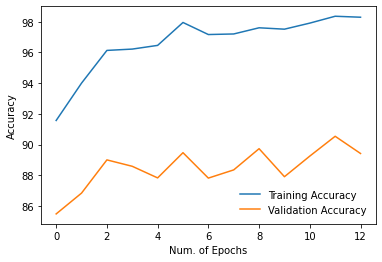

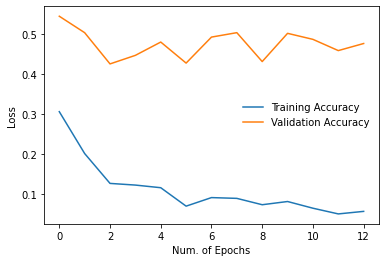

In [19]:
# Accuracy
import matplotlib.pyplot as plt

plt.plot(training_history["accuracy"], label="Training Accuracy")
plt.plot(validation_history["accuracy"], label="Validation Accuracy")
plt.xlabel("Num. of Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

# Loss
plt.plot(training_history["loss"], label="Training Accuracy")
plt.plot(validation_history["loss"], label="Validation Accuracy")
plt.xlabel("Num. of Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

### Loading the saved model from the disk

In [17]:
# loading the saved model
# def fetch_last_checkpoint_model_filename(model_save_path):
#     import os
#     checkpoint_files = os.listdir(model_save_path)
#     checkpoint_files = [f for f in checkpoint_files if '.pth' in f]
#     checkpoint_iter = [
#         int(x.split('_')[2].split('.')[0])
#         for x in checkpoint_files]
#     last_idx = np.array(checkpoint_iter).argmax()
#     return os.path.join(model_save_path, checkpoint_files[last_idx])

# model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('./saved_models')))
# model.load_state_dict(torch.load('./saved_models/aksarabali_aksarabali_11256.pt'))
print("Model Loaded")

Model Loaded
